In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Generate training data
np.random.seed(42)
num_samples = 1000
x_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
t_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
u_exact = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

# Convert to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)

# Combine x and t for training input
input_train = tf.concat([x_train_tf, t_train_tf], axis=1)

# Generate test data for prediction
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Convert to TensorFlow tensors
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)

input_test = tf.concat([x_test_tf, t_test_tf], axis=1)

u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)

In [3]:
model=Sequential([
    # tf.keras.Input((1000,2)),
    Dense(units=50,activation='tanh'),
    Dense(units=50,activation='tanh'),
    Dense(units=1,activation='linear')
])

In [4]:
def loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat((x, t), axis=1))
        du_x = tape.gradient(u_pred, x)
        du_xx = tape.gradient(du_x, x)
        du_dt = tape.gradient(u_pred, t)
        del tape

    alpha = 0.00001
    physics_residual = du_dt - alpha * du_xx
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    data_loss = tf.reduce_mean(tf.square(u_pred - u_exact_tf))
    total_loss = physics_loss + data_loss
    
    return total_loss, physics_loss, data_loss

In [5]:
from tensorflow.keras.optimizers import Adam

In [6]:
optimizer=Adam(learning_rate=1e-3)

In [7]:
num_epochs = 2000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        total_loss, physics_loss_value, data_loss_value = loss(model, x_train_tf, t_train_tf)
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {physics_loss_value.numpy()}, Data Loss: {data_loss_value.numpy()}")

Epoch 0/2000, Total Loss: 0.1492920070886612, Physics Loss: 0.06443122774362564, Data Loss: 0.08486077934503555
Epoch 100/2000, Total Loss: 0.020517004653811455, Physics Loss: 0.0005799927748739719, Data Loss: 0.01993701234459877
Epoch 200/2000, Total Loss: 0.020449349656701088, Physics Loss: 0.0006622961955145001, Data Loss: 0.019787052646279335
Epoch 300/2000, Total Loss: 0.02042492851614952, Physics Loss: 0.0006989562534727156, Data Loss: 0.019725972786545753
Epoch 400/2000, Total Loss: 0.020409628748893738, Physics Loss: 0.0007125575793907046, Data Loss: 0.019697071984410286
Epoch 500/2000, Total Loss: 0.020393051207065582, Physics Loss: 0.0007153751794248819, Data Loss: 0.019677676260471344
Epoch 600/2000, Total Loss: 0.020373482257127762, Physics Loss: 0.0007165680872276425, Data Loss: 0.019656913354992867
Epoch 700/2000, Total Loss: 0.020349079743027687, Physics Loss: 0.0007180866086855531, Data Loss: 0.01963099278509617
Epoch 800/2000, Total Loss: 0.020316338166594505, Physics 

In [8]:
u_pred_test = model(tf.concat([input_test], axis=1))

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
# Calculate Mean Squared Error
mse = mean_squared_error(u_exact_test_tf, u_pred_test)
print(f"Mean Squared Error: {mse}")

# Calculate Mean Absolute Error
mae = mean_absolute_error(u_exact_test_tf, u_pred_test)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.004212760366499424
Mean Absolute Error: 0.05768800899386406


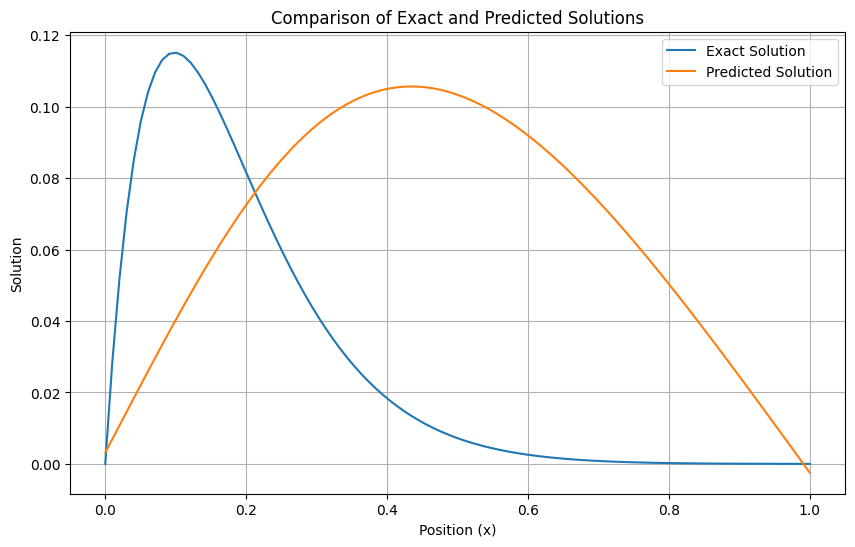

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_test, u_exact_test, label='Exact Solution')
plt.plot(t_test, u_pred_test, label='Predicted Solution')
plt.xlabel('Position (x)')
plt.ylabel('Solution')
plt.title('Comparison of Exact and Predicted Solutions')
plt.legend()
plt.grid(True)
plt.show()